In [15]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings

### Control parameters

In [16]:
GPWDEVICEDIR = '../dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = '../dft/leads/'

In [17]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [18]:
lowdin = True
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao

Condition number: 2.7e+04


In [19]:
def get_species_indices(species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

In [20]:
bridge_indices = get_species_indices(BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

## LCAO Hamiltonian (Hamiltonian obtained directly from gpaw)

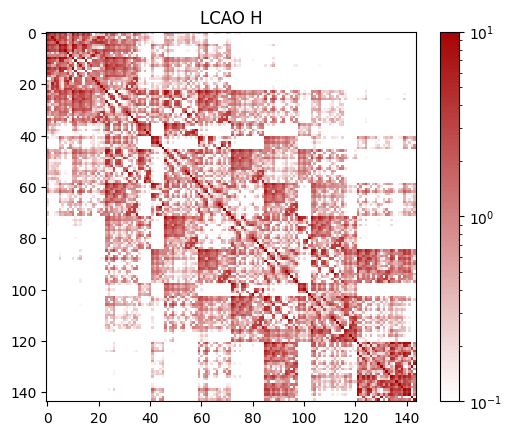

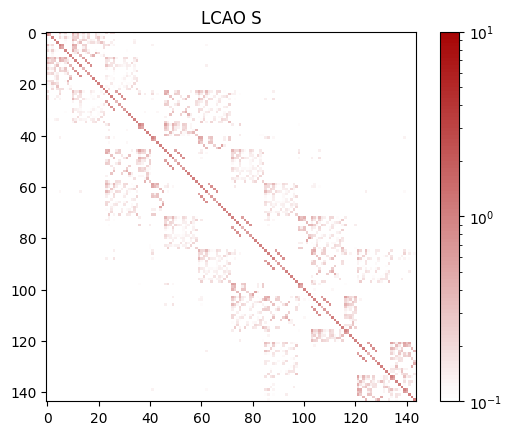

In [21]:
bridge_region_H_lcao = H_lcao[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_lcao = S_lcao[bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_lcao), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("LCAO H")
plt.show()
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_S_lcao), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("LCAO S")
plt.show()

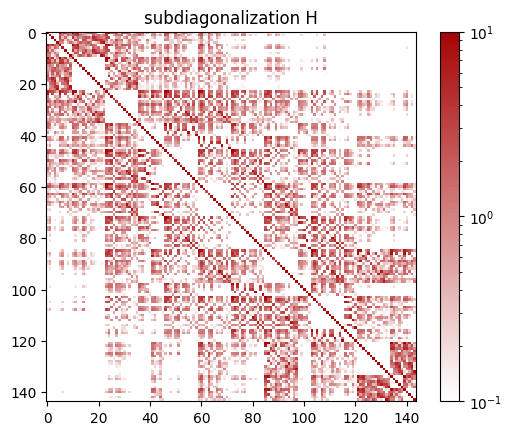

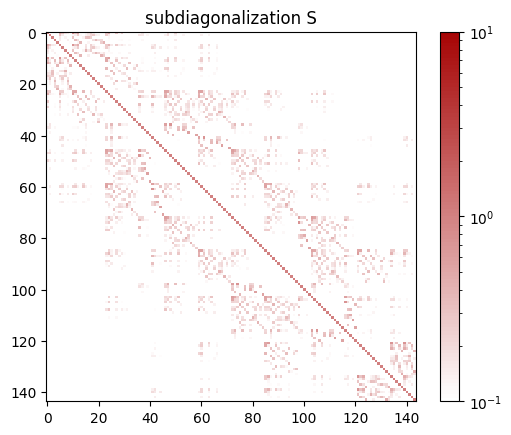

In [26]:
SUBDIAG_SPECIES = ("C","N","H")
subdiag_indices = get_species_indices(SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)
H_sub_device = rotate_matrix(H_lcao, Usub)[None,...]
S_sub_device = rotate_matrix(S_lcao, Usub)[None,...]

bridge_region_H_sub = H_sub_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
bridge_region_S_sub = S_sub_device[0,bridge_start:bridge_end+1,bridge_start:bridge_end+1]
fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization H")
plt.show()

fig, ax = plt.subplots()
cax = ax.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
cbar = fig.colorbar(cax)
plt.title("subdiagonalization S")
plt.show()

In [27]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_leads_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

In [28]:
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, (5, 4, 2), align=(0, H_sub_device[0, 0, 0]))
remove_pbc(device_basis, H_sub_device)
remove_pbc(device_basis, S_sub_device)

Nr = (1, 4, 2)

self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij),
                            Nr=Nr,
                            id='right')

rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

nodes = graph_partition.get_tridiagonal_nodes(device_basis, H_sub_device[0],
                                              len(leads_atoms.repeat(Nr)))


hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes, H_sub_device[0], S_sub_device[0])

de = 0.2
energies = np.arange(-2., 2. + de / 2., de).round(7)
eta = 1e-3

gf = greenfunction.GreenFunction(hs_list_ii,
                                    hs_list_ij,
                                    [(0, self_energy[0]),
                                    (len(hs_list_ii) - 1, self_energy[1])],
                                     solver='coupling',
                                    eta=eta)

T = np.empty(energies.size)

for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)


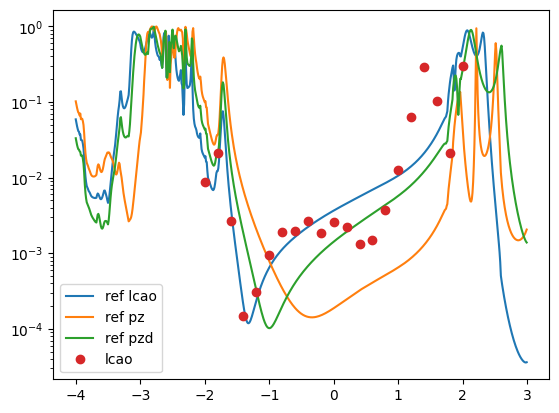

In [31]:
ref_path = "published_reference/transmission"
Tref_lcao = np.loadtxt(f"{ref_path}/ET_hs.dat")
Tref_pz = np.loadtxt(f"{ref_path}/ET_pz.dat")
Tref_pzd = np.loadtxt(f"{ref_path}/ET_pzd.dat")

plt.plot(Tref_lcao[:,0],Tref_lcao[:,1],label="ref lcao")
plt.plot(Tref_pz[:,0],Tref_pz[:,1],label="ref pz")
plt.plot(Tref_pzd[:,0],Tref_pzd[:,1],label="ref pzd")
plt.plot(energies,T,'o',label="lcao")
plt.yscale("log")
plt.legend()